In [14]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import glob
import pickle
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scanpy as sc
import sys
sys.path.append('/home/ngr4/project/scripts/')
import utils

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc.settings.n_jobs=-1
sns.set_style("ticks")



The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [15]:
# aesthetics
# cmap_timepoint = {v:sns.light_palette((210, 90, 60), input="husl")[1:][i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

cmap_timepoint = {v:sns.color_palette('BuGn')[1:][i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

cmap_genotime = {}
for g in ['WT', 'SCA1']:
    if g=='WT':
        for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk']):
            cmap_genotime['{}_{}'.format(g, v)] = sns.cubehelix_palette(5, start=.5, rot=-.75)[i]
    if g=='SCA1':
        for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk']):
            cmap_genotime['{}_{}'.format(g, v)] = sns.cubehelix_palette(5)[i]
            
cmap_ctype={'Granule cell': '#FAC18A',
            'Unipolar brush cell': '#BA61BA',
            'Purkinje cell': '#EE5264',
            'GABAergic interneuron 1': '#F9EBAE',
            'GABAergic interneuron 2': '#88BB92',
            'GABAergic interneuron 3': '#46A928',
            'Astrocyte': '#F9AEAE',
            'Bergmann glia': '#AEB7F9',
            'Oligodendrocyte progenitor cell': '#F1815F',
            'Oligodendrocyte': '#75A3B7',
            'Microglia': '#AC5861',
            'Pericyte': '#2D284B',
            'Endothelial cell': '#1C67EE'}

cmap_genotype={'WT':'#010101',
               'SCA1':'#ffd478'}



In [3]:
# data
if False:
    # do the human ones
    pdfp = '/home/ngr4/project/scnd/data/processed'
    pfp = '/home/ngr4/project/scnd/results/'

    # load human
    fname='hum_MT_bbknn.h5ad'
    %memit hdata = utils.load_adata(os.path.join(pdfp, fname))
    
    if True : # not encoded yet
        hdata.obs['genotype']=['SCA1' if 'SCA' in i else 'WT' for i in hdata.obs['Sample']]
        
if False:
    pdfp = '/home/ngr4/project/scnd/data/processed'
    pfp = '/home/ngr4/project/scnd/results/'
    
    %memit adata = utils.load_adata(os.path.join(pdfp, 'mouse_200614.h5ad'))
    
if True:
    pdfp = '/home/ngr4/project/scnd/data/processed'
    pfp = '/home/ngr4/project/scnd/results/'

    %memit wtt = utils.load_adata(os.path.join(pdfp, 'mouse_wt_imputed.h5ad'))
    %memit mutt = utils.load_adata(os.path.join(pdfp, 'mouse_sca1_imputed.h5ad'))
    
    

loaded @200811.13:21:23
took 39.78-s to load data
peak memory: 38662.25 MiB, increment: 38461.59 MiB
loaded @200811.13:22:00
took 36.51-s to load data
peak memory: 74516.28 MiB, increment: 35861.51 MiB


# Check expression

## Unipolar brush cell cluster

In [6]:
goi = [
    'Gria2',
    'Tbr1',
    'En1',
    'En2',
    'Grm1',
    'Calb2',
    'Plcb4',
    'Tmem163',
    'Meis2',
    'Lhx2',
    'Lhx9',
    'Grem2',
      ]

In [7]:
x = pd.DataFrame(wtt[:, goi].X.todense(), columns=goi, index=wtt.obs.index)
x['ctype'] = wtt.obs['ctype'].to_list()
x['genotype'] = wtt.obs['genotype'].to_list()
x['timepoint'] = wtt.obs['timepoint']
y = pd.DataFrame(mutt[:, goi].X.todense(), columns=goi, index=mutt.obs.index)
y['ctype'] = mutt.obs['ctype'].to_list()
y['genotype'] = mutt.obs['genotype'].to_list()
y['timepoint'] = mutt.obs['timepoint']

X = x.append(y)
X = X.melt(id_vars=['ctype','genotype','timepoint'], value_name='Expression (imputed)', var_name='Marker')
del x,y

X.head()

,Gria2,Tbr1,En1,En2,Grm1,Calb2,Plcb4,Tmem163,Meis2,Lhx2,Lhx9,Grem2,ctype,genotype,timepoint
AAACCCAAGAGTGGCT-1-7202,0.809644,0.0,0.0,0.000000,0.000000,1.145010,1.145010,0.000000,0.0,0.0,0.0,0.0,Bergmann glia,WT,5wk
AAACCCAAGCAAACAT-1-7202,1.891377,0.0,0.0,0.000000,0.000000,0.000000,1.891377,0.000000,0.0,0.0,0.0,0.0,Granule cell,WT,5wk
AAACCCACAGAGGAAA-1-7202,0.000000,0.0,0.0,0.893206,0.000000,0.000000,1.263184,0.000000,0.0,0.0,0.0,0.0,Astrocyte,WT,5wk
AAACCCACAGCGTTGC-1-7202,1.633897,0.0,0.0,0.471665,2.161442,0.471665,1.564337,1.491537,0.0,0.0,0.0,0.0,Granule cell,WT,5wk
AAACCCACATCGCTCT-1-7202,1.378866,0.0,0.0,0.000000,1.950011,0.000000,2.180178,2.180178,0.0,0.0,0.0,0.0,Granule cell,WT,5wk


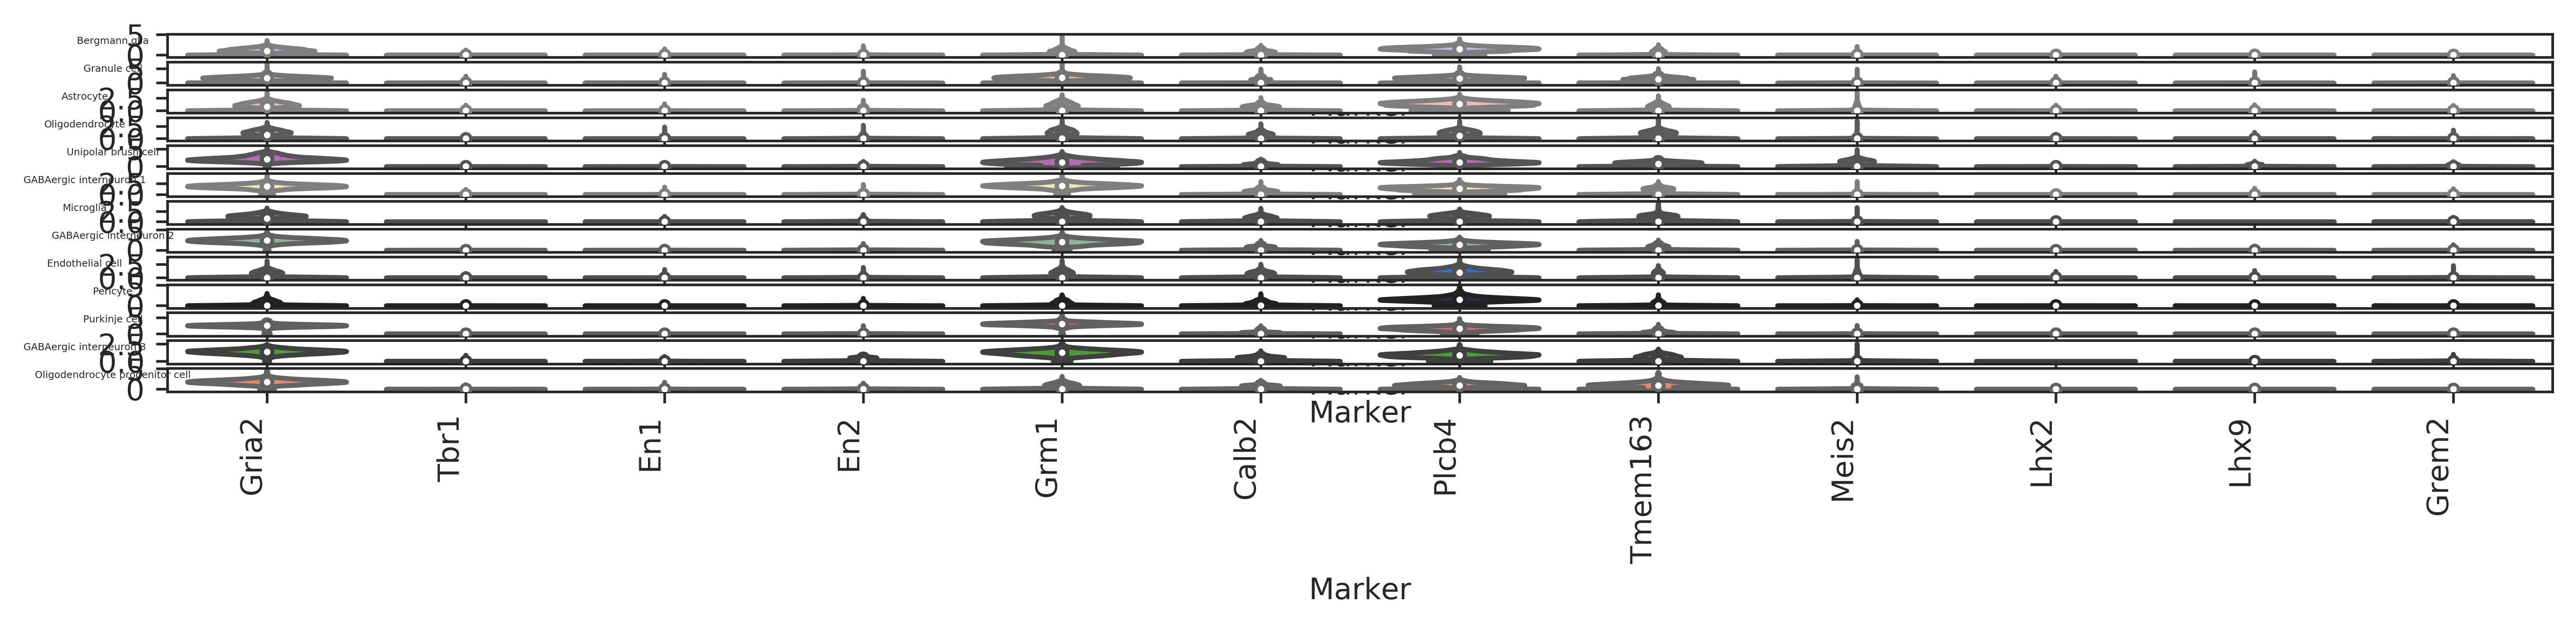

In [28]:
fig, ax = plt.subplots(13, 1, figsize=(13,2))
for i,c in enumerate(X['ctype'].unique()):
    sns.violinplot(
        x='Marker',
        y='Expression (imputed)',
        hue='ctype',
        data=X.loc[X['ctype']==c, :],
        order=goi,
        hue_order=None,
        bw='scott',
        cut=2,
        scale='area',
        scale_hue=True,
        gridsize=100,
        width=0.8,
        inner='box',
        split=False,
        dodge=False,
        orient=None,
        linewidth=None,
        color=None,
        palette=cmap_ctype,
        saturation=0.75,
        ax=ax[i],
    )
    
    ax[i].legend().set_visible(False)
    ax[i].set_ylabel('{}'.format(c), rotation=0, fontsize=3)
    if i==(len(X['ctype'].unique()) - 1):
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right')
    else:
        ax[i].set_xticklabels([])

fig.savefig(os.path.join(pfp, 'marker_chk.png'), bbox_inches='tight')
    